<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/inpainting/deepfillv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Deepfillv2 only(Inpainting)
!git clone https://github.com/csqiangwen/DeepFillv2_Pytorch.git

In [ ]:
%cd DeepFillv2_Pytorch

In [ ]:
!pip install imgcrop

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-

In [ ]:
!python3 test.py --baseroot './test_data/' --baseroot_mask './test_data_mask/' --results_path './results' --gan_type 'WGAN' --gpu_ids '1' --epoch 40 --batch_size 1 --num_workers 8 --pad_type 'zero' --activation 'elu' --norm 'none'

In [ ]:
#@title cutler with deepfillv2
%cd /content
!git clone --recursive https://github.com/facebookresearch/CutLER
%cd CutLER/
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install git+https://github.com/mcordts/cityscapesScripts.git
!pip install -r requirements.txt

In [ ]:
%cd cutler/demo

In [11]:
import argparse
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import cv2
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
sys.path.append('./')
sys.path.append('../')
from config import add_cutler_config
from predictor import VisualizationDemo

In [12]:
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_cutler_config(cfg)
    # To use demo for Panoptic-DeepLab, please uncomment the following two lines.
    # from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config  # noqa
    # add_panoptic_deeplab_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Disable the use of SyncBN normalization when running on a CPU
    # SyncBN is not supported on CPU and can cause errors, so we switch to BN instead
    if cfg.MODEL.DEVICE == 'cpu' and cfg.MODEL.RESNETS.NORM == 'SyncBN':
        cfg.MODEL.RESNETS.NORM = "BN"
        cfg.MODEL.FPN.NORM = "BN"
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg

In [13]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input", help="path to the input image",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.35,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [15]:
!wget http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth

--2023-02-20 00:18:36--  http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574672112 (548M) [binary/octet-stream]
Saving to: ‘cutler_cascade_final.pth’

cutler_cascade_fina 100%[===================>] 548.05M  36.5MB/s    in 16s     

2023-02-20 00:18:52 (35.3 MB/s) - ‘cutler_cascade_final.pth’ saved [574672112/574672112]



In [14]:
# provide arguments for running CutLER demo.

# Note: to run on cpu, add "MODEL.DEVICE", "cpu" after --opts. to run on GPU, remove "MODEL.DEVICE", "cpu".
# Note: please specify a path with "--input" if you want to try your own images.
# Note: you can use a lower --confidence-threshold to get a higher recall.
mp.set_start_method("spawn", force=True)
inputs = ['--config-file', "../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml", '--input', "/content/DeepFillv2_Pytorch/test_data/1.png", '--confidence-threshold', '0.5', "--opts", "MODEL.WEIGHTS", "cutler_cascade_final.pth", "MODEL.DEVICE", "cpu"]
args = get_parser(inputs)

In [16]:
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)

[02/20 00:37:20 detectron2]: Arguments: Namespace(confidence_threshold=0.5, config_file='../model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', input='/content/DeepFillv2_Pytorch/test_data/1.png', opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'], output=None, video_input=None, webcam=False)
[02/20 00:37:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[02/20 00:37:21 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...


In [17]:
# use PIL, to be consistent with evaluation
img = read_image(args.input, format="BGR")
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
logger.info(
    "{}: {} in {:.2f}s".format(
        args.input,
        "detected {} instances".format(len(predictions["instances"]))
        if "instances" in predictions
        else "finished",
        time.time() - start_time,
    )
)

# save image to your local directory
if args.output:
    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(args.input))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/20 00:37:35 detectron2]: /content/DeepFillv2_Pytorch/test_data/1.png: detected 2 instances in 8.31s


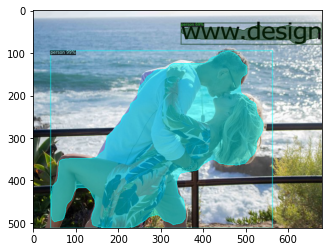

In [19]:
plt.imshow(visualized_output.get_image())

In [ ]:
predictions  # visualized_output

In [25]:
predictions["instances"].pred_masks.shape

torch.Size([2, 512, 680])

In [38]:
import cv2
import numpy as np
rgbimage = cv2.imread("/content/DeepFillv2_Pytorch/test_data/1.png")
mask_r = predictions["instances"].pred_masks.cpu().numpy().astype('uint8')[0]
image = np.ones_like(rgbimage) * 255
masked_r = cv2.bitwise_and(image, image, mask=mask_r)

In [ ]:
import os
os.makedirs("/content/inputs/images", exist_ok=True)
os.makedirs("/content/inputs/masks", exist_ok=True)

imgname = "000"
cv2.imwrite(f"/content/inputs/images/{imgname}.png", rgbimage)
cv2.imwrite(f"/content/inputs/masks/{imgname}.png", masked_r)

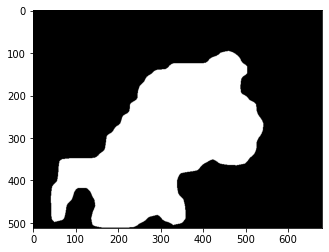

In [39]:
plt.imshow(masked_r)

In [42]:
# another deepfillv2_pytorch
%cd /content/
!git clone https://github.com/nipponjo/deepfillv2-pytorch.git

/content
Cloning into 'deepfillv2-pytorch'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 176 (delta 23), reused 101 (delta 15), pack-reused 57
Receiving objects: 100% (176/176), 3.41 MiB | 22.98 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [44]:
%cd deepfillv2-pytorch

/content/deepfillv2-pytorch


In [45]:
# places weights
!gdown https://drive.google.com/u/0/uc?id=1L63oBNVgz7xSb_3hGbUdkYW1IuRgMkCa&export=download&confirm=t&uuid=234f4a84-0298-471b-a532-0452dfc51775&at=ALgDtsyPJHkogIyk_ZTcDk74jc3b:1676854660069

Downloading...
From: https://drive.google.com/u/0/uc?id=1L63oBNVgz7xSb_3hGbUdkYW1IuRgMkCa
To: /content/deepfillv2-pytorch/states_pt_places2.pth
100% 120M/120M [00:00<00:00, 173MB/s]


In [50]:
# celebhq weights
!gdown https://drive.google.com/u/0/uc?id=17oJ1dJ9O3hkl2pnl8l2PtNVf2WhSDtB7&export=download&confirm=t&uuid=2f8419e9-e87b-41e6-b1c9-2dcd6a96186b&at=ALgDtswN3TrmqneBQfCJ0_DCU3ns:1676854936749

Downloading...
From: https://drive.google.com/u/0/uc?id=17oJ1dJ9O3hkl2pnl8l2PtNVf2WhSDtB7
To: /content/deepfillv2-pytorch/states_pt_celebahq.pth
100% 120M/120M [00:01<00:00, 110MB/s]


In [51]:
!python test.py --image /content/inputs/images/000.png --mask /content/inputs/masks/000.png --out /content/results/case000_out_test.png --checkpoint states_pt_celebahq.pth

Shape of image: torch.Size([1, 3, 512, 680])
Saved output file at: /content/results/case000_out_test.png


In [41]:
# inference with deepfillv2
%cd /content/DeepFillv2_Pytorch
!python3 test.py --baseroot '/content/inputs/images' --baseroot_mask '/content/inputs/masks' --results_path '/content/results' --gan_type 'WGAN' --gpu_ids '1' --epoch 40 --batch_size 1 --num_workers 8 --pad_type 'zero' --activation 'elu' --norm 'none'

/content/DeepFillv2_Pytorch
Generator is created!
Initialize generator with xavier type
-------------------------Loading Pretrained Model-------------------------
-------------------------Pretrained Model Loaded-------------------------
The overall number of images equals to 1
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
----------------------batch_idx1 has been finished----------------------


In [ ]:
#@title Tips
# 消しゴムマジックはある程度小さなものに対して機能する。でかいものに対してはうまく機能しない、、
# cutlerよりもyolov8とかの方がマスクの精度はいいかもしれない。